In [14]:
import struct
import matplotlib.pyplot as plt
import numpy as np

f=open('Jan9e10.D24','rb')
file=f.read()



In [15]:

def search (data,format:str,start:int,end:int,size:int):
    #Extrae la información de un archivo en binario, se debe indicar el tipo de datos "format" y el tamaño, en bytes, del tipo de dato "size".
    list=[]
    position=-1
    for byte in data[start:end+1]:
        position+=1 
        if position%size==0:
           i=position+start
           val=(struct.unpack(format,data[i:i+size]))[0]
           list.append(val)
        else:
           continue     
    return list


In [16]:
def header (data):
    #Extrae la información del header de lor archivos de collect y la almacena en un diccionario. 
    note_list=search(file,'c',28,106,1)    
    note=''    
    for letter in note_list:
        if letter == b'\x00':
            break
        str_letter=letter.decode('ascii')
        note+=str_letter  
    header= {
        'nch': (struct.unpack('b',data[:1]))[0], #numero de canales
        'gain': search(data,'b',1,4,1), #ganancia en cada canal
        'global_freq': struct.unpack('f',data[5:9])[0],
        'eq_freq': struct.unpack('b',data[9:10])[0], #frecuencia igual/desigual
        't_points': int(struct.unpack('f',data[10:14])[0]), #número total de puntos
        'ad_resol': struct.unpack('b',data[14:15])[0],  #Resolución análogo digital
        'aux_channel':struct.unpack('b',file[111:112])[0],
        'aux_val':search(file,'f',112,127,4),
        'note':note,
    }
    return header


In [ ]:

def channels(data):
    head=header(file)
    raw_points=search(file,'H',128,128+head['t_points']*2,2) #t_points*2, porque mide 2 bytes cada punto
    zero=2**(head['ad_resol']-1)
    points=[point-zero for point in raw_points]
    count=0
    ch1=[]
    ch2=[]
    for point in points:
        if count%2==0:
            ch1.append(point)
        else:
            ch2.append(point)
        count+=1
    ch1=[point/(head['gain'][0]*32) for point in ch1]
    ch2=[point/(head['gain'][1]*32) for point in ch2]
    fig, ax = plt.subplots(2)             
    ax[0].plot(ch1)
    ax[1].plot(ch2)  
    return fig,ch1,ch2



[-11.90625, -11.96875, -11.84375, -11.6875, -11.90625, -11.65625, -11.90625, -11.84375, -11.8125, -11.78125, -11.75, -11.71875, -11.71875, -11.71875, -11.84375, -11.71875, -11.46875, -11.71875, -11.5625, -11.59375, -11.53125, -11.75, -11.78125, -11.65625, -11.84375, -11.59375, -11.65625, -11.71875, -11.8125, -11.46875, -11.65625, -11.625, -11.71875, -11.65625, -11.65625, -11.71875, -11.59375, -11.71875, -11.65625, -11.78125, -11.84375, -11.8125, -11.59375, -11.59375, -11.71875, -11.90625, -11.71875, -11.65625, -11.625, -11.96875, -11.78125, -11.8125, -11.84375, -11.875, -11.84375, -11.96875, -11.96875, -12.09375, -12.03125, -11.875, -12.15625, -11.90625, -12.03125, -12.03125, -12.21875, -12.28125, -12.15625, -12.15625, -12.4375, -12.21875, -12.3125, -12.375, -12.34375, -12.46875, -12.1875, -12.40625, -12.375, -12.34375, -12.28125, -12.28125, -12.28125, -12.3125, -12.15625, -12.09375, -12.5625, -12.28125, -12.375, -12.21875, -12.34375, -12.28125, -12.125, -12.375, -12.21875, -12.125, -1

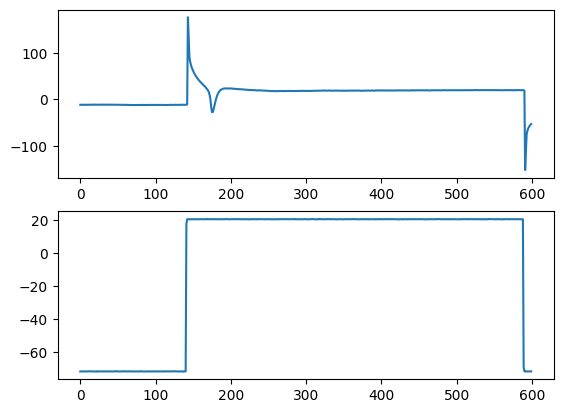

In [20]:
fig,ch1,ch2=channels(file)

print(ch1)
print(ch2)